## Import packages

In [24]:
%matplotlib inline
import math
import pandas as pd
import matplotlib.pyplot as plt
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from CFModel import CFModel, DeepModel

## Define constants


In [25]:
RATINGS_CSV_FILE = 'ml1m_ratings.csv'
MODEL_WEIGHTS_FILE = 'ml1m_weights.h5'
K_FACTORS = 200
RNG_SEED = 1231

## Load MovieLens 1M data

In [31]:
ratings = pd.read_csv(RATINGS_CSV_FILE, 
                      sep='\t', 
                      encoding='latin-1', 
                      usecols=['userid', 'movieid', 'user_emb_id', 'movie_emb_id', 'rating'],
                     )
max_userid = ratings['userid'].drop_duplicates().max()
max_movieid = ratings['movieid'].drop_duplicates().max()
print len(ratings), 'ratings loaded.'

1000209 ratings loaded.


## Create training set

In [32]:
shuffled_ratings = ratings.sample(frac=1., random_state=RNG_SEED)
Users = shuffled_ratings['user_emb_id'].values
print 'Users:', Users, ', shape =', Users.shape
Movies = shuffled_ratings['movie_emb_id'].values
print 'Movies:', Movies, ', shape =', Movies.shape
Ratings = shuffled_ratings['rating'].values
print 'Ratings:', Ratings, ', shape =', Ratings.shape

Users: [1997 3961 5268 ..., 1644 5947 4421] , shape = (1000209,)
Movies: [2940 3248 3357 ..., 1102 1944  911] , shape = (1000209,)
Ratings: [3 4 4 ..., 5 5 5] , shape = (1000209,)


## Define model

In [33]:
model = DeepModel(max_userid, max_movieid, K_FACTORS, p_dropout=.3)
model.compile(loss='mse', optimizer='adagrad')

## Train model

In [34]:
callbacks = [EarlyStopping('val_loss', patience=2), 
             ModelCheckpoint(MODEL_WEIGHTS_FILE, save_best_only=True)]
history = model.fit([Users, Movies], Ratings, epochs=50, validation_split=.15, verbose=1, callbacks=callbacks)

Train on 850177 samples, validate on 150032 samples
Epoch 1/50
850177/850177 [==============================] - 199s - loss: 0.9188 - val_loss: 0.8192
Epoch 2/50
850177/850177 [==============================] - 201s - loss: 0.8547 - val_loss: 0.8008
Epoch 3/50
850177/850177 [==============================] - 201s - loss: 0.8370 - val_loss: 0.7943
Epoch 4/50
850177/850177 [==============================] - 201s - loss: 0.8266 - val_loss: 0.7884
Epoch 5/50
850177/850177 [==============================] - 202s - loss: 0.8179 - val_loss: 0.7854
Epoch 6/50
850177/850177 [==============================] - 202s - loss: 0.8129 - val_loss: 0.7822
Epoch 7/50
850177/850177 [==============================] - 201s - loss: 0.8077 - val_loss: 0.7805
Epoch 8/50
850177/850177 [==============================] - 200s - loss: 0.8038 - val_loss: 0.7785
Epoch 9/50
850177/850177 [==============================] - 199s - loss: 0.7999 - val_loss: 0.7762
Epoch 10/50
850177/850177 [==============================

## Plot training and validation RMSE

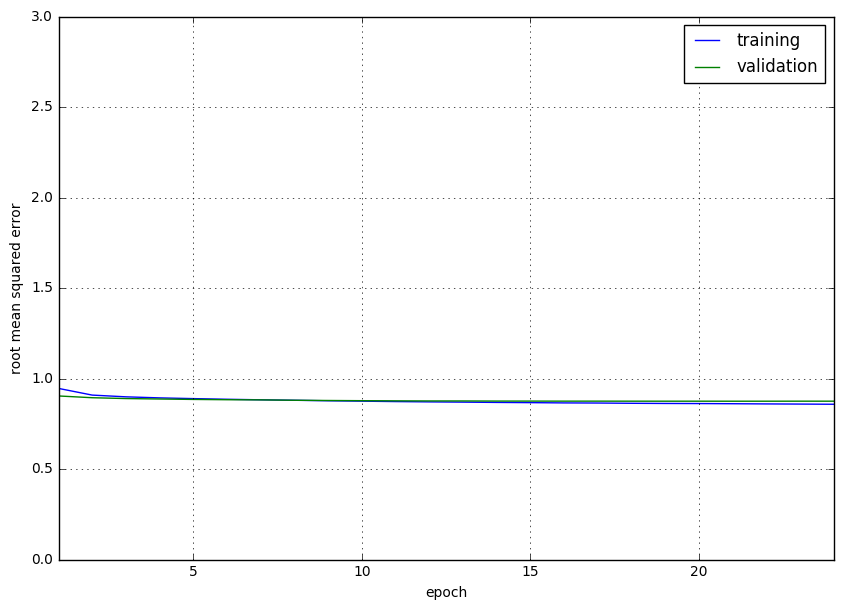

In [19]:
loss = pd.DataFrame({'epoch': [ i + 1 for i in history.epoch ],
                     'training': [ math.sqrt(loss) for loss in history.history['loss'] ],
                     'validation': [ math.sqrt(loss) for loss in history.history['val_loss'] ]})
ax = loss.ix[:,:].plot(x='epoch', figsize={7,10}, grid=True)
ax.set_ylabel("root mean squared error")
ax.set_ylim([0.0,3.0]);

## Print best validation RMSE

In [22]:
min_val_loss, idx = min((val, idx) for (idx, val) in enumerate(history.history['val_loss']))
print 'Minimum RMSE at epoch', '{:d}'.format(idx+1), '=', '{:.4f}'.format(math.sqrt(min_val_loss))

Minimum RMSE at epoch 21 = 0.8753


In [23]:
model.save_weights('my_model_weights.h5')